# Detecting outlyers with minimal volume ellipse





In [41]:
%matplotlib inline

# Future 
from __future__ import print_function

# Numpy imports 
import numpy as np
import numpy.random as random

import scipy as sp
import scipy.linalg as la


# Convex optimization package: CVXOPT

## Import the basic packages
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False

## Import the CVXOPT version of LAPACK
from cvxopt import blas, lapack, sqrt, mul, cos, sin, log

# Import matplotlib.pyplot
import matplotlib.pyplot as plt



EPS = sp.finfo(float).eps


# 2D scatter plot example 

(-2.0, 10.0, 2.0, 9.0)

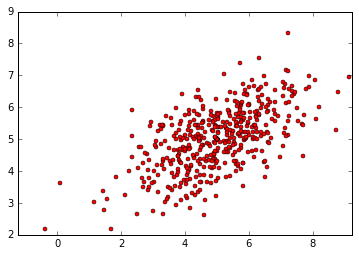

In [42]:
# Generate random samples for testing the algorithm 
mean = np.array([5.0, 5.0])
cov = np.array([[2.0, 0.9], 
                [0.9, 1.0]])
Nsamples = 500
samples = random.multivariate_normal(mean, cov, Nsamples)
samples[:50] = random.laplace(5, scale =.0000001, size=(50, 2))
plt.plot(samples[:, 0], samples[:, 1], 'or', markersize=4)
plt.axis('equal')





In [43]:
# Define function for various array calculations

## Parameterization of the ellipse as a single vector
D = sp.zeros((5, 2, 2), dtype=float)
D[2:] = sp.array([[[1, 0], 
                   [0, 0]], 
                  [[0, 1], 
                   [1, 0]], 
                  [[0, 0], 
                   [0, 1]]])
                
B = sp.zeros((5, 2), dtype=float)
B[:2] = sp.array([[1, 0], [0, 1]])
#print(D, end='\n\n')
#print(B)
    
## Functions
def get_A(a):
    return sp.tensordot(D, a, axes=[(0,), (0,)])
def get_b(a):
    return sp.tensordot(B, a, axes=[(0,), (0,)])

## Cost function 
def get_f0(a):
    "Compute the objective function: -log(det(A(a)))."
    A = get_A(a)
    return -1.0 * sp.log(la.det(A))
    
def grad_f0(a, D=D):
    "Compute the gradient of the objective function: -log(det(A(a)))."
    A = get_A(a)
    Ainv = la.inv(A)
    E = sp.dot(Ainv, D).transpose(1,0,2)
    out = -sp.trace(E, axis1=1, axis2=2)
    return out

def hess_f0(a, D=D):
    "Compute the hessian of the objective function: -log(det(A(a)))."
    A = get_A(a)
    Ainv = la.inv(A)
    E = sp.dot(Ainv, D).transpose(1,0,2)
    EE = sp.dot(E, E).trace(axis1=1, axis2=3)
    H = (1.0 / 2.0) * (EE + EE.T)
    return H
     

In [44]:
## Check the derivative calculations    
a0 = sp.array([.10, .10, .050, 0.005, .050])

msg = "The objective value is f0: \n\t{0}\nThe gradient grad(f0) is :\n\t{1}\n\n"
print(msg.format(get_f0(a0), grad_f0(a0)))

df0 = grad_f0(a0)
h = 1e-7 * df0

grad_diff = (get_f0(a0 + h) - get_f0(a0 - h))/(2 * la.norm(h))
grad_func = la.norm(df0)
hess_diff = (get_f0(a0 + h) - 2.0 * get_f0(a0) + get_f0(a0 - h)) / (la.norm(h))**2
hess_func = sp.dot(h, sp.dot(hess_f0(a0), h)) / (la.norm(h)**2)


msg = "Gradient error :   {0}"
print(msg.format(abs(grad_diff - grad_func) / grad_diff))
msg = "Hessian error  :   {0}"
print(msg.format(abs(hess_diff - hess_func) / hess_diff))

The objective value is f0: 
	6.00151488296
The gradient grad(f0) is :
	[ -0.          -0.         -20.2020202    4.04040404 -20.2020202 ]


Gradient error :   7.28400429043e-10
Hessian error  :   3.8241376524e-07


In [45]:
# Define the constraint function

## The constraint function 
def get_f1(a, x=samples, B=B, D=D):
    "Define the nth constraint function."
    b = get_b(a)
    A = get_A(a)
    Ax = sp.dot(A, x.T)
    val = ((b[:, None] + Ax[:, :])**2).sum(0) - 1.0
    return val

def grad_f1(a, x=samples, B=B, D=D):
    "Define the gradient for each convex inequality."
    b = get_b(a)
    A = get_A(a)
    Ax = sp.dot(A, x.T)
    vec0 = b[:, None] + Ax[:, :]                      #  in
    vec1 = B[:, :, None] + sp.dot(D, x.T)[:, :, :]    # kin
    vec_isum = 2.0 * (vec0[None, :, :] * vec1[:, :, :]).sum(1).transpose()
    return vec_isum

def hess_f1(a, x=samples, B=B, D=D):
    "Define the hessians for each convex inequality."
    vec1 = B[:, :, None] + sp.dot(D, x.T)[:, :, :]    # kin -> nkk'
    vec_kkn = 2.0 * (vec1[:, None, :, :] * vec1[None, :, :, :]).sum(2)
    vec_nkk = vec_kkn.transpose(2,0,1)
    return vec_nkk

In [46]:
## Check the derivative calculations    
a0 = sp.array([.10, .10, .050, 0.005, .050])

msg = "The objective value is f1: \n\t{0}\nThe gradient grad(f0) is :\n\t{1}\n\n"
print(msg.format(get_f0(a0), grad_f0(a0)))

f10 = lambda a: get_f1(a)[0]
grad_f10 = lambda a: grad_f1(a)[0]
hess_f10 = lambda a: hess_f1(a)[0]

df0 = grad_f10(a0)
h = 1e-7 * df0

grad_diff = (f10(a0 + h) - f10(a0 - h))/(2 * la.norm(h))
grad_func = la.norm(df0)
hess_diff = (f10(a0 + h) - 2.0 * f10(a0) + f10(a0 - h)) / (la.norm(h))**2
hess_func = sp.dot(h, sp.dot(hess_f10(a0), h)) / (la.norm(h)**2)


msg = "Gradient error :   {0}"
print(msg.format(abs(grad_diff - grad_func) / grad_diff))
msg = "Hessian error  :   {0}"
print(msg.format(abs(hess_diff - hess_func) / hess_diff))

The objective value is f1: 
	6.00151488296
The gradient grad(f0) is :
	[ -0.          -0.         -20.2020202    4.04040404 -20.2020202 ]


Gradient error :   6.3722472113e-12
Hessian error  :   1.10544301767e-06


## Define the interface function for CVXOPT

In [47]:
# Loewner-John ellipsoid
#
# minimize     log det A^-1
# subject to   || A(a) x_n + b(a) ||_2^2  - 1.0 <= 0  for  n=1,...,m
#
# 5 variables a = [b0, b1, A00, A01, A11]

def F(a=None, z=None, a0=a0, x=samples, B=B, D=D):
    
    # Convert input to numpy arrays
    n = a0.size
    m = x.shape[0]
    
    ## Handle the case for determining the initial value
    if a is not None:
        a = sp.array(a).reshape(n)
    else:
        return m, matrix(a0)
    
    
    ## Calculations 
    if z is not None: 
        z = sp.array(z).reshape(m + 1)
        
        ## Compute the full outputHessian
        fout = sp.zeros([m+1])
        dfout = sp.zeros([m+1, n])
        ddfout = sp.zeros([n, n])

        fout[0] = get_f0(a)
        dfout[0] = grad_f0(a)
        ddfout[:, :] += z[0] * hess_f0(a)
        
        fout[1:] = get_f1(a)
        dfout[1:, :] = grad_f1(a)
        ddfout[:, :] += (z[1:, None, None] * hess_f1(a)).sum(0)
         
        # Return the full output
        return (matrix(fout.reshape(m+1, 1)), 
                matrix(dfout), 
                matrix(ddfout))
    
    else:
        
        # Check the domain
        A = get_A(a)
        lams = la.eigvalsh(A)
        if lams.min() <= -10 * EPS:
            return (None, None)
        
        ## Compute partial output without hessian
        fout = sp.zeros([m+1])
        dfout = sp.zeros([m+1, n])

        fout[0] = get_f0(a)
        dfout[0] = grad_f0(a)
        
        fout[1:] = get_f1(a)
        dfout[1:, :] = grad_f1(a)

        return (matrix(fout.reshape(m+1, 1)), 
                matrix(dfout))
  


## Solve for the minimum volume ellipsoid containing all the points


In [48]:
sol = solvers.cp(F)
solx = np.array(sol['x']).flatten()
print(solx)
b = get_b(solx)
A = get_A(solx)

Ainv = la.inv(A)

print(A)
print(Ainv)
print(b)

[-0.49784113 -1.39398823  0.24283676 -0.13693586  0.40486982]
[[ 0.24283676 -0.13693586]
 [-0.13693586  0.40486982]]
[[ 5.08848757  1.72103817]
 [ 1.72103817  3.05202257]]
[-0.49784113 -1.39398823]


# Make a plot showing min. vol ellipsoid

(-2.0, 12.0, 1.0, 9.0)

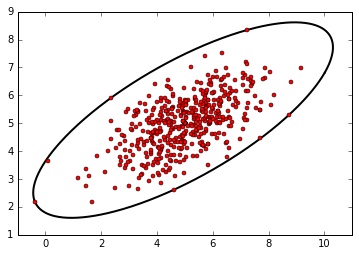

In [49]:
circle = sp.array([[cos(phi), sin(phi)] for phi in sp.linspace(0, 2.0*sp.pi, 513)[:-1]])


Ainv = la.inv(A)

ellipse = sp.dot(circle-b, Ainv)


plt.plot(ellipse[:, 0], ellipse[:, 1], '-k', linewidth=2)
plt.plot(samples[:, 0], samples[:, 1],'or', markersize=4)
plt.axis('equal')

# Determine candidats for removal

(-2.0, 12.0, 1.0, 9.0)

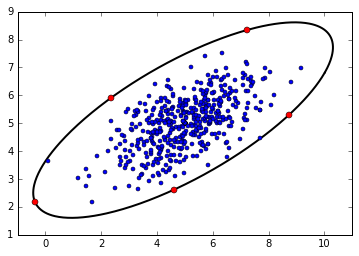

In [50]:
def xinxout(x, A=A, b=b):
    "Define the signed distance to the boundary."
    v = sp.dot(A, x.T) + b[:, None]
    Iinside = la.norm(v, axis=0) <  (1 - sp.sqrt(EPS))
    #print(Iinside)
    xin = x[Iinside, :]
    xout = x[~Iinside, :]
    return xin, xout

xin, xout = xinxout(samples)
plt.plot(ellipse[:, 0], ellipse[:, 1], '-k', linewidth=2)
plt.plot(xin[:, 0], xin[:, 1],'ob', markersize=4)
plt.plot(xout[:, 0], xout[:, 1],'or', markersize=6)
plt.axis('equal')
